# Reporte de problemas fitosanitarios en plantaciones de agave
--------------------

## Equipo 36

| Nombre | Matrícula |
| ------ | --------- |
| André Martins Cordebello | A00572928 |
| Enrique Eduardo Solís Da Costa | A00572678 |
| Delbert Francisco Custodio Vargas | A01795613 |

## Avance 2: Feature engineering

- Crear nuevas características para mejorar el rendimiento de los modelos.
- Mitigar el riesgo de características sesgadas y acelerar la convergencia de algunos algoritmos.

# Feature Engineering

## EDA

Durante el avance 1 fue posible comprender ciertos comportamientos de nuestro dataset, así como la selección de columnas que sí aportaban información para entender de mejor manera las características de infección de gorgojos del agave en predios del mismo.

Con esto, usando como base los datasets compartidos por la CNIT fue posible obtener el dataset llamada `all_historic_captures.xlsx`, el cual contiene información del 2014 a Agosto de 2025 sobre el nivel de incidencia o infección encontrado  en predios de agave. Estas muestras se obtuvieron con base a las condiciones definidas en el **Manual Operativo de la campaña contra plagas reglamentadas del Agave**, disponible en https://www.gob.mx/cms/uploads/attachment/file/234136/Manual_Operativo_de_la_campa_a_contra_plagas_reglamentadas_del_agave_2017.compressed.pdf, lo cual fue confirmado por nuestro Sponsor (CNIT).

Por lo anterior, el objetivo principal de este proyecto integrador es el desarrollo de un ChatBot el cual:

- Pueda recibir reportes que incluyan ubicación, breve descripción de lo encontrado, fotografías y clasificación de riesgo de parte del cuerpo técnico y ciudadanía en general.
- Este ChatBot también debe tener la capacidad de responder y alertar a los usuarios sobre focos de infección reportados o confirmados en las cercanías.

La recepción de esta información es importante ya que permitirá tomar decisiones sobre lo que las brigadas de desinfección deben atacar primero.

Por lo anterior, durante nuestro EDA (análisis exploratorio) encontramos los siguientes hallazgos:

- La captura de gorgojos del agave en las trampas tiende a aumentar en épocas lluviosas.
- Los focos de infección severos y moderados tienen una dispersión geográfica menor.
- No es normal encontrar predios de más de 8 años de antiguedad, lo que nos da una idea de cuáles predios podrían estar posiblemente abandonados.
- La mayor densidad de trampas se encuentra en el estado de Jalisco.
- No es normal encontrar focos severos de infección, pero la presencia de éstos aumenta en la época lluviosa. Es posible confirmar que los casos severos de infección son casos atípicos, ya que el valor del percentil 95 se encuentra en 17.5 capturas por trampa.
- Durante la pandemia (2020 a 2024 aproximadamente), el muestreo de las trampas colocadas no fue tan constante como en años posteriores o previos a la pandemia. Esto causa un efecto de sesgo en nuestro dataset.


Y al transformar un poco nuestro dataset obtuvimos estas columnas finales:

| Feature  | Tipo | Notas |
| -------  | ---- | ----- |
| tramp_id | object | Es el ID único que se le da a la trampa al colocarse en alguna parcela o predio. Una misma trampa puede colocarse en distintos predios, pero la identificación de la misma cambia acorde a dónde se colocó. |
| sampling_date | datetime64[ns] | Es la fecha en la que se llevó a cabo el conteo de cadáveres de gorgojo en la trampa.|
| lat y lon | float64 | La `latitud` y `longitud` permiten conocer la ubicación de donde se llevó a cabo el muestreo. |
| municipality | object | Municipio al que pertenecía la trampa al momento de hacer el muestreo. |
| square_area | float64 | Area que cubre el predio donde se colocó la trampa. |
| plantation_age | float64 | Años que una plantación de agave tiene desde la última purga. |
| capture_count | float64 | Cantidad de gorgojos del agave encontrados dentro de la trampa. |
| state | object | Estado de México donde se encontraba la trampa colocada. |
| severity | object | lLa severidad de la infestación encontrada durante el muestreo. Estos niveles fueron definidos por la SICAFI.|
| Month | int32 | Mes en que se llevó a cabo el muestreo de la trampa. |
| Year | int32 | Año en que se llevó a cabo el muestreo de la trampa. |
| MonthName | object | Nombre del   mes en que se llevó a cabo el muestreo de la trampa. |
| MonthYear | datetime64[ns] |  Combinación del año y mes en que se llevó a cabo el muestreo de la trampa. Esta ya es una característica creada a partir de otras columnas del Dataset. |

Con esto, estaremos trabajando la ingeniería de característiscas con base en estas columnas.

### Librerías  a importar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os


plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### Cargamos el dataset obtenido anteriormente

In [2]:
# Carga de dataset
all_historic_captures_df = pd.read_excel( "all_historic_captures.xlsx", sheet_name="historic_captures", header= 0)

# Eliminamos las columnas que usamos para llevar a cabo una mejor comprensión en el EDA,
# esto porque debemos decidir más adelante si serán necesarias para nuestro proceso de FE.
all_historic_captures_df.drop(labels=['Month', 'Year', 'MonthName', 'MonthYear', 'plantation_age_group', 'surface_group', 'no_area'],axis=1, inplace=True)

all_historic_captures_df.head(5)

,tramp_id,sampling_date,lat,lon,municipality,square_area,plantation_age,capture_count,state,severity
0,146_THUE13-11-023-0637T01,2022-07-21,20.401984,-101.702729,PÉNJAMO,1.75,0,8.0,GUANAJUATO,1-25
1,146_THUE13-11-023-0637T01,2022-04-19,20.401984,-101.702729,PÉNJAMO,1.75,0,5.0,GUANAJUATO,1-25
2,146_THUE13-11-023-0637T01,2022-02-25,20.401984,-101.702729,PÉNJAMO,1.75,0,5.0,GUANAJUATO,1-25
3,146_THUE13-11-023-0637T01,2022-02-14,20.401984,-101.702729,PÉNJAMO,1.75,0,4.0,GUANAJUATO,1-25
4,146_THUE13-11-023-0637T01,2022-05-18,20.401984,-101.702729,PÉNJAMO,1.75,0,6.0,GUANAJUATO,1-25


### `Feature engineering` sobre `square_area`

Al revisar nuevamente los valores de `square_area` (o `Superficie (ha)` originalmente), es posible notar que casi el 48% de éstos es igual a `0.00`. Esto, como discutimos con anterioridad, indica que durante el proceso de muestreo de años previos a 2024 y 2025 no hubo un control de calidad para mitigar la falta de información en esta columna. Esto fue confirmado por nuestro Sponsor.

Pero como consideramos que esta información es importante, hemos decidido trabajar la siguiente estrategia de imputación:

- Reducir la cantidad de valores `0.00` por medio del `ID de cada trampa`. Como el ID de la trampa está en función del predio muestreado, es posible asumir que con que un ID de trampa contenga información del área, esta se puede replicar a las demás instancias de ese mismo ID de trampa en el tiempo.

- Luego de esto, usaremos un algoritmo conocido como K-NN (K nearest neighbour) para verificar cuales trampas con un registro de superficie distinto a `0.00` se encuentran cerca de otras trampas con un área distinta a `0.00`. La distancia entre éstas trampas debe ser de un mínimo de 100m hasta 500m en época de jima según el manual de operación.

- Después de usar K-NN, haremos uso también de `RadiusNeighborsRegressor`, el cual toma en cuenta la distancia entre los puntos para asumir si se encuentran cerca o no. 

- Por último, analizaremos cuántos registros quedan pendientes aún de tener un valor distinto a `0.00` y decidiremos más adelante qué hacer con ellos.

In [3]:
df = all_historic_captures_df

print(f"Trampas registradas con área mayor a 0.00: { (df['square_area'] > 0 ).sum()}")
print(f"Trampas registradas con área igual a 0.00: { (df['square_area'] == 0 ).sum()}")


Trampas registradas con área mayor a 0.00: 428434
Trampas registradas con área igual a 0.00: 399422


##### Usando el ID de trampa para llenar valores vacíos

In [4]:
import warnings
warnings.filterwarnings('ignore')

def get_nearest_temporal_area_group(group_to_verify):

    # Casteamos datetime sobre sampling_date (fecha de muestreo)
    group = group_to_verify.copy()
    group['sampling_date_dt'] = pd.to_datetime(group['sampling_date'])
    
    # Tomamos solo las areas mayores a 0.00
    areas_known = group.loc[group['square_area'] > 0.00, ['sampling_date_dt', 'square_area']]
    if areas_known.empty:
        return pd.Series(np.nan, index=group.index)
    
    # Calculamos la diferencia de tiempo en dias
    diffs = np.abs(
        group['sampling_date_dt'].values[:, None] - areas_known['sampling_date_dt'].values[None, :]
    )
    
    # Tomamos la muestra con menor tiempo en comparación con la fecha que estamos revisando
    idxmin = diffs.argmin(axis=1)
    
    return pd.Series(areas_known['square_area'].iloc[idxmin].values, index=group.index)


# Generamos una copia de  la columna square_area
df['square_area_imputed'] = df['square_area'].copy()

# Generamos la columna de imputation_method: con lo siguiente:
# Si el area es mayor a 0.00, entonces colocamos 'original'
# Si el area es menor a 0.00, la marcamos para insertar valores
df['imputation_method'] = np.where(df['square_area'] > 0, 'original', 'none')

# Generamos una máscara para el dataframe
mask = df['square_area'] == 0

# Usamos la función para encontrar el area más próxima a cada tramp_id con area 0.00
nearest_values = (
    df.groupby('tramp_id', group_keys=False)
      .apply(get_nearest_temporal_area_group)
)

# Insertamos los valores al dataframe original 
# Insertamos la forma en que se llenó la informacion del area
df.loc[mask, 'square_area_imputed'] = nearest_values[mask]
df.loc[mask & nearest_values.notna(), 'imputation_method'] = 'same_trap_id_temporal'

rows_affected = df[ df['imputation_method'] == 'same_trap_id_temporal']
print(f"Se llenaron { len(rows_affected) } registros usando el mismo ID de la trampa en el tiempo.")

Se llenaron 79287 registros usando el mismo ID de la trampa en el tiempo.


##### Ahora usaremos KNN para rellenar el resto de información

- `original`: son todas los registros de area que originalmente son distintos a 0.00
- `none`: son los registros que aún no hemos imputado
- `samte_trap_id_temporal`: son los registros que tienen un valor imputado en la columna `square_area_imputed` por medio de usar el `trap_id` y verificar la muestra más cercana en el tiempo que tenga area mayor a 0.00.

Algo importante es que debemos asignarle al parámetro `weights` la opción de `distance`, ya que de ésta forma se pondera la distancia para darle más importancia a los vecinos más cercanos al punto que estamos analizando.

In [5]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
import warnings

print("\nOrigen de los valores de la columna square_area_imputed:")
print(df['imputation_method'].value_counts())

# Ignoraremos warnings
warnings.filterwarnings('ignore')

# No debemos  sobre-escribir lo que ya imputamos anterioremente
# Entonces usaremos esos indexes como mascara
train_mask = df['imputation_method'].isin(['original', 'same_trap_id_temporal'])

# Tomamos los indexes que ya sabemos que en teoría están bien
X_train = df[train_mask][['lat', 'lon']].values
y_train = df[train_mask]['square_area_imputed'].values

# Nuestro test serán los registros de los que sabemos que tienen 0.00 en square_area
# y que no han sido imputados por el paso previo.
test_mask = df['imputation_method'] == 'none'
X_test = df[test_mask][['lat', 'lon']].values

print(f"Registros a predecir su quare_area: {len(X_test):,}")


Origen de los valores de la columna square_area_imputed:
imputation_method
original                 428434
none                     320135
same_trap_id_temporal     79287
Name: count, dtype: int64
Registros a predecir su quare_area: 320,135


In [6]:
# Usaremos Harversine para tomar en cuenta la curvatura de la tierra en la distancia que usemos para conocer cuales trampas están
# cerca unas de otras, y se necesita que las longitudes y latitudes estén en radianes
X_train_rad = np.radians(X_train)
X_test_rad = np.radians(X_test)


# Modelo 1: 4 trampas mas cercanas
knn_1 = KNeighborsRegressor(
    n_neighbors=4,
    weights='distance',
    metric='haversine',
    n_jobs=-1
)

knn_1.fit(X_train_rad, y_train)
predictions_1 = knn_1.predict(X_test_rad)

# Modelo 2: 5 trampas mas cercanas
knn_2 = KNeighborsRegressor(
    n_neighbors=5,
    weights='distance',
    metric='haversine',
    n_jobs=-1
)

knn_2.fit(X_train_rad, y_train)
predictions_2 = knn_2.predict(X_test_rad)

También entrenamos el modelo `RadiusNeighborsRegressor`.

In [7]:
# Modelo 3: las trampas contenidas en 500m a la redonda
knn_3 = RadiusNeighborsRegressor(
    radius = 0.250/6378, # 500 metros dentro de 6378 km del radio de la tierra
    weights='distance',
    metric='haversine' 
)

knn_3.fit(X_train_rad, y_train)
predictions_3 = knn_3.predict(X_test_rad)

In [8]:
def print_descriptive_stats_for_knn_model( title, preds ):
    
    print('='*70)
    print(f"{title}")
    print('='*70)
    print(f"Promedio: {np.nanmean(preds)}")
    print(f"Mediana: {np.nanmedian(preds)}")
    print(f"Desviacion estandar: {np.nanstd(preds)}")
    print(f"Valor maximo: {np.nanmax(preds)}")
    print(f"Valor mínimo: {np.nanmin(preds)}")
    print(f"Cantidad de trampas sin área registrada: {np.isnan(preds).sum()}\n")

print_descriptive_stats_for_knn_model('Estadísticas para el modelo #1 sobre el area:', predictions_1)
print_descriptive_stats_for_knn_model('Estadísticas para el modelo #2 sobre el area:', predictions_2)
print_descriptive_stats_for_knn_model('Estadísticas para el modelo #3 sobre el area:', predictions_3)

already_imputed_mask = df['imputation_method'].isin(['original', 'same_trap_id_temporal'])
print_descriptive_stats_for_knn_model('Estadísticas de los datos originales con area mayor a 0.00:', df[already_imputed_mask][df['square_area'] > 0.00000].square_area)

Estadísticas para el modelo #1 sobre el area:
Promedio: 11.716221848897428
Mediana: 5.933797917355816
Desviacion estandar: 16.74506939865329
Valor maximo: 294.428330125542
Valor mínimo: 0.0384
Cantidad de trampas sin área registrada: 0

Estadísticas para el modelo #2 sobre el area:
Promedio: 11.719764276551983
Mediana: 5.999999999999999
Desviacion estandar: 16.65718356129089
Valor maximo: 289.0736297284621
Valor mínimo: 0.041383444025189134
Cantidad de trampas sin área registrada: 0

Estadísticas para el modelo #3 sobre el area:
Promedio: 9.640752701065155
Mediana: 4.940517107486462
Desviacion estandar: 13.89220421396947
Valor maximo: 300.00000000000006
Valor mínimo: 0.15000000000000002
Cantidad de trampas sin área registrada: 57837

Estadísticas de los datos originales con area mayor a 0.00:
Promedio: 9.700518487656419
Mediana: 3.7473
Desviacion estandar: 18.117772785301234
Valor maximo: 787.82
Valor mínimo: 0.00469999993219971
Cantidad de trampas sin área registrada: 0



#### Justificación sobre uso de modelos #2 y #3 en conjunto

Al revisar los resultados con cada modelo para obtener el area en los predios donde no se contaba con esta información, nos dimos cuenta de lo siguiente:

- El modelo #3, que usa `RadiusNeighborsRegressor` reportó las estadísticas descriptivas más parecidas a la información original. La desventaja de este modelo es que nos deja `57,837` trampas como aisladas, y por lo tanto, sin área.
- Los modelos #1 y #2, al usar un algoritmo `KNeighborsRegressor` con `K=4` y `K=5` respectivamente, logran rellenar toda la información faltante, pero notamos que las estadísticas descriptivas que generan son un poco más alejadas que las de las originales. Esto sobre todo en la `media` y `mediana`.

Por lo anterior, decidimos hacer uso de la siguiente estrategia:

- Usar `RadiusNeighborsRegressor` para rellenar la información del área en las trampas posibles.
- Las trampas restantes que queden sin valor (`57,837`) harán uso de `KNeighborsRegressor` con un `K=5` para no tener valores faltantes en la columna de `square_area_imputed`.

Se decidió mantener la columna original `square_area` para términos de mantener la información original para estudios posteriores.

In [9]:
test_indices = df[test_mask].index

# Creamos otra máscara para insertar valores predecidos por los modelos #2 y #3
# Como el modelo #3 es el que tiene las características descriptivas más parecidas a los valores originales,
# usaremos ese de primero para insertar valores.
model3_valid_mask = ~np.isnan(predictions_3)
model3_nan_mask = np.isnan(predictions_3)

df.loc[test_indices[model3_valid_mask], 'square_area_imputed'] = predictions_3[model3_valid_mask]
df.loc[test_indices[model3_valid_mask], 'imputation_method'] = 'knn_radius'

# Luego insertaremos las predicciones hechas con el modelo KNN con 4 vecinos
df.loc[test_indices[model3_nan_mask], 'square_area_imputed'] = predictions_2[model3_nan_mask]
df.loc[test_indices[model3_nan_mask], 'imputation_method'] = 'knn_5'

# Imprimimos cuántos valores NaN o None nos quedan por rellenar aun
remaining_nan = df['square_area_imputed'].isna().sum()
remaining_none = (df['imputation_method'] == 'none').sum()

print(f"Valores NaN en square_area_imputed: {remaining_nan}")
print(f"Registros con método 'none': {remaining_none}")

if remaining_nan == 0 and remaining_none == 0:
    print("Todos los valores se han rellenado.")
else:
    print("\nSe deben rellenar aún más valores.\n\n")
    
df['imputation_method'].value_counts()

Valores NaN en square_area_imputed: 0
Registros con método 'none': 0
Todos los valores se han rellenado.


imputation_method
original                 428434
knn_radius               262298
same_trap_id_temporal     79287
knn_5                     57837
Name: count, dtype: int64

### `Feature engineering` sobre `sampling_date`

Primero obtendremos de nuevo las columnas de `Year` y `Year-Month` desde la fecha de muestreo. Estas variables son lineales, por lo tanto solo debemos normalizarlas o escalarlas.

Respecto a `month`, `day_of_year`, `day_of_week` y `week_of_year` usaremos la representación trigonométrica (coseno y seno) para mantener las distancias entre mese, incluyendo el fin de año e inicio de año. Esto debido a que en el EDA fue bastante notorio que existe  un ciclo en la presencia del gorgojo de la siguiente manera:

- De Enero a Mayo la cantidad de gorgojos encontrados fue menor que la cantidad de gorgojos muestreados de Junio a Diciembre.
- Nuestro Sponsor considera que esto se debe a las lluvias, y  por lo tanto más adelante incluiremos la cantidad de mm de lluvia registrada por municipio y estado (esto con la ayuda del sitio oficial del gobierno de México)
- Es necesario mantener la relación de Diciembre a Enero, y para esto se presta el uso de un encoding cíclico.
- Al usar un encoding ciclico en los meses, días y semanas normalizamos la data en  un solo paso.
- Una razón importante de implementar estos cambios es que todos se pueden obtener de la fecha de muestreo o reporte, por lo que al implementar el ChatBot esta información se podrá obtener solo con la fecha de reporte.

In [10]:
df['month']        = df['sampling_date'].dt.month
df['year']         = df['sampling_date'].dt.year
df['year_month']   = df['sampling_date'].dt.strftime('%Y-%m')

# Hacemos el encoding trigonometrico para day_of_year (preserva la distancia de Diciembre a Enero tambien)
df['day_of_year_sin'] = np.sin( 2 * np.pi * df['sampling_date'].dt.dayofyear / 365 )
df['day_of_year_cos'] = np.cos( 2 * np.pi * df['sampling_date'].dt.dayofyear / 365 )

# Es probable que el día de la semana funcione también, y es necesario preservar la distancia de domingo a lunes y viceversa
df['day_of_week_sin'] = np.sin( 2 * np.pi * df['sampling_date'].dt.day_of_week / 7 )
df['day_of_week_cos'] = np.cos( 2 * np.pi * df['sampling_date'].dt.day_of_week / 7 )

# Trabajamos lo mismo con week_of_year
df['week_of_year_sin'] = np.sin( (df['sampling_date'].dt.isocalendar().week/ 52 * 2 * np.pi) )
df['week_of_year_cos'] = np.cos( (df['sampling_date'].dt.isocalendar().week/ 52 * 2 * np.pi) )

# Encodeamos el mes tambien
df['month_sin'] = np.sin( (df['sampling_date'].dt.month / 12 * 2 * np.pi) )
df['month_cos'] = np.cos( (df['sampling_date'].dt.month / 12 * 2 * np.pi) )

El manual operativo de protección fitosanitaria menciona también que la época crítica de monitoreo se encuentra definida de Mayo a Septiembre, por lo que agregaremos una columna la cual tenga los siguientes valores:

- `critica` para la temporada de lluvias definida en el manual operativo.
- `normal` para la temporada que no se considera como de lluvia en el manual operativo.

In [11]:
critical_months = [ 5, 6, 7, 8, 9 ]

#  Usamos list comprehension
df['critical_season'] = [ 1 if m in critical_months else 0 for m in df['month'] ]

### `Feature engineering` para características espaciales

Es importante conocer la densidad de la presencia de trampas para que nuestro ChatBot pueda responder si la ubicación enviada se encuentra cerca de alguno de los puntos de infección recientes, y dar un mejor contexto a los usuarios.

Para esto, hemos decidido crear los siguientes features:

- `distance_to_nearest_hotspot`
- `hotspots_within_1km`
- `hotspots_within_5km`

Y para definir un hotspot tenemos la siguiente opción:

- Usar la actual escala `severity` de nuestro dataset y hacer encoding sobre ésta, ya que según el manual operativo se cuenta con 4 niveles de infestación:
    - `Primer nivel`: se presenta cuando en las trampas no hay presencia de gorgojos.
    - `Segundo nivel`: se da cuando en las trampas se halla presencia de entre 1 a 24 gorgojos.
    - `Tercer nivel`: se considera cuando en una trampa se encuentran 25 a 75 gorgojos.
    - `Cuarto nivel`: se presenta cuando en las trampas se encuentran más de 75 gorgojos. Esto se considera como un foco de infestación, porque representa una media de 5 gorgojos muestreados por día en 15 días.

Entonces el primer paso es hacer encoding sobre estos niveles, los cuales son una variable ordinal (ya que se presenta una escala de mejor a peor escenario), y debemos codificarlos de manera que el LLM a implementar pueda relacionar el nivel de riesgo que cada foco implica. 

In [61]:
print(f"Nivel original de severidad:\n\n{df['severity'].value_counts()}")

print("="*70)
severity_mapping = {
     '0'    : 0,
     '1-25' : 1,
     '25-75': 2,
     '>75'  : 3
}

df['severity_encoded'] = df['severity'].map(severity_mapping)
df['severity_encoded'] = df['severity_encoded'].astype(int)
print( f"Nivel codificado de severidad:\n\n{df['severity_encoded'].value_counts()}")

Nivel original de severidad:

severity
1-25     518659
0        291465
25-75     16476
>75        1256
Name: count, dtype: int64
Nivel codificado de severidad:

severity_encoded
1    518659
0    291465
2     16476
3      1256
Name: count, dtype: int64


Y ahora que ya tenemos definido el nivel de riesgo por cada trampa muestreada, es posible  iniciar a definir las variables `distance_to_nearest_hotspot`, `hotspots_between_5km` y `hotspots_between_10km` respectivamente, ya que éstas le darán más contexto al LLM. Y para reducir la ventana de búsqueda, haremos uso de una ventana de tiempo de 15 días.

In [13]:
from datetime import datetime, timedelta
# Funcion para usar la distancia usando la formula de Harversine

def distance_between_traps(lat1, lon1, lat2, lon2):
    # Radio de la tierra
    r = 6371.0
    
    # Volvemos radianos las ubicaciones
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Diferencia entre latitudes y longitudes en radianes
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Formular de Harversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    distance = r * 2 * np.arcsin(np.sqrt(a))
    # Resultado
    return distance

In [87]:
# Funcion para tomar en  cuenta la cantidad de hotspots a 5km y 10km que estuvieron presentes durante los 15 días previos y posteriores a la muestra
# si se requiere, se pueden cambiar los dias previos y posteriores a analizar por fecha de muestreo.
# Si no se encuentra alguna trampa cercana como hotspot a la trampa a analizar, entonces usaremos el valor 9999 km para
# que nuestro LLM entienda que el riesgo de un hotspot está lejos
from scipy.spatial import cKDTree

def proximity_to_hotspots(df, days_before=15, days_after=15):
    
    df = df.sort_values("sampling_date").reset_index(drop=True)
    df["sampling_date"] = pd.to_datetime(df["sampling_date"])

    hotspots = df[df["is_hotspot"]][["sampling_date", "lat", "lon"]].copy()
    hotspots["sampling_date"] = pd.to_datetime(hotspots["sampling_date"])

    # Inicializamos las salidas (se crean las nuevas columnas)
    # Si no se encuentra alguna trampa cercana, dejaremos 9999 como el valor predeterminado
    df["distance_to_nearest_hotspot"] = 9999
    df["hotspots_within_1km"] = 0
    df["hotspots_within_5km"] = 0

    # Usaremos fechas unicas para procesar de a poco cada valor
    unique_dates = df["sampling_date"].sort_values().unique()

    # Iniciamos el ciclo por fecha unica
    for current_date in unique_dates:
        
        # Fecha minima y maxima a calcular por cada trampa
        date_min = current_date - timedelta(days=days_before)
        date_max = current_date + timedelta(days=days_after)

        # Tomamos las trampas por fecha unica
        df_subset = df[df["sampling_date"] == current_date]
        
        # buscamos los hotspots en los 15 dias previos y posteriores
        hot_subset = hotspots[
            (hotspots["sampling_date"] >= date_min) & 
            (hotspots["sampling_date"] <= date_max)
        ]

        if len(hot_subset) == 0 or len(df_subset) == 0:
            continue

        # Armamos un arbol KDT
        tree = cKDTree(np.radians(hot_subset[["lat", "lon"]].values))

        # 
        trap_coords = np.radians(df_subset[["lat", "lon"]].values)

        
        try:
            # Para Scipy 1.9 o superior
            dists, _ = tree.query(trap_coords, k=1, workers=-1)
        except TypeError:
            # Para versiones antiguas de SciPy (como la nuestra)
            dists, _ = tree.query(trap_coords, k=1)

        dists_km = dists * 6371  # convert radians to km

        
        count_1km = tree.query_ball_point(trap_coords, r=1/6371, workers=-1)
        count_5km = tree.query_ball_point(trap_coords, r=5/6371, workers=-1)

        idx = df_subset.index
        df.loc[idx, "distance_to_nearest_hotspot"] = dists_km
        df.loc[idx, "hotspots_within_1km"] = [len(c) for c in count_1km]
        df.loc[idx, "hotspots_within_5km"] = [len(c) for c in count_5km]

    return df

severe_risk_capture_threshold = 75

df['is_hotspot'] = (
    (df['capture_count'] > severe_risk_capture_threshold) | (df['severity_encoded'] == 3 )
)

df = proximity_to_hotspots(df) # Obtendremos la cantidad de hotspots a 5km y 10km en los 15 dias previos y futuros por defecto, y la distancia al hotspot mas cercano.

### ¿`Feature engineering` sobre `Estado` y `Municipalidad`?

Antes de analizar estas columnas, debemos corregir 2 aspectos que se encuentran presentes en el Dataset:

- Cambiar `Michoacan de Ocampo` por `Michoacan`.
- Cambiar el estado de `Ixtlan del Rio` a `Nayarit`

In [88]:
import unicodedata
import re

# Primero corregimos Michoacan de Ocampo para que forme parte de la categoría 'Michoacan'
df['state'].replace('MICHOACÁN DE OCAMPO', 'MICHOACAN', inplace=True)

# Corregimos las instancias de Ixtlan del 
df.loc[df['municipality'] == 'IXTLÁN DEL RÍO', 'state'] = 'NAYARIT'

# Aprovechamos a eliminar tildes

def remove_accents(text):
    if pd.isna(text):
        return text
    
    return ''.join(c for c in unicodedata.normalize('NFKD', str(text)) if not unicodedata.combining(c))

def clean_text(text):
    if pd.isna(text):
        return text
    text = remove_accents(text)
    return re.sub(r'[^A-Za-z0-9\s]', '', text).upper()

state_municipality_cols = ['state', 'municipality']

for col in state_municipality_cols:
    df[col] = df[col].apply(remove_accents)
    
for col in state_municipality_cols:
    df[col] = df[col].apply(clean_text)

In [89]:
print(f"Valores únicos para State: {df['state'].nunique()}")
print(f"Valores únicos para Municipality: {df['municipality'].nunique()}")

Valores únicos para State: 5
Valores únicos para Municipality: 149


Luego de esto, hemos decidido no llevar a cabo algún encoding para estas columnas por los siguientes motivos:

- El LLM que se utilice para desarrollar el ChatBot puede hacer uso de estos textos para dar respuestas descriptivas. No es lo mismo alimentar al ChatBot haciendo uso de valores como `1`, `2` o `3` que `Jalisco`, `Nayarit` y `Michoacan`, por ejemplo.
- La investigación de Koloski *et al.* indica que el uso de text embeddings para LLMs ayuda a que el LLM tenga un mejor resultado acorde a lo que se le cuestione. Por lo tanto, tendremos que convertir nuestra data tabular a embeddings para lograr que nuestro ChatBot responda de mejor manera usando el contexto  que nuestro dataset le dé.
<br>
<br>

### `Feature engineering` para `Text Embeddings`

Ahora que hemos generado múltiples features (16 aproximadamente), se procederá a crear **features de texto normalizadas** para el entrenamiento del LLM y el sistema RAG:

**Features de texto principales:**
1. **`text_feature_location`**: Ubicación geográfica la cual incluye el municipio, estado y coordenadas junto al tamaño del predio y edad de plantación.

2. **`text_feature_risk`**: Evaluación de riesgo basada en densidad de focos de infestación cercanos (distancia al foco severo más cercano, focos severos a 5km y 10km), y la condición propia del foco de infestación. 

3. **`text_feature_capture`**: Reporte de captura con fecha, cantidad de gorgojos, nivel de severidad descriptivo, y contexto de temporada crítica o no. 

4. **`text_feature_plantation`**: Características del predio (área con método de obtención, edad del cultivo, estado de desarrollo) contextualizadas en términos agrícolas.

5. **`text_feature_all_things`**: Columna compuesta que integra información temporal, espacial y de riesgo.


**Normalización de texto aplicada:**
- Conversión de valores discretos (como la severidad) a texto.
- Estandarización de categorías por medio del uso de diccionarios.
- Inclusión explícita de unidades (kilómetros, hectáreas, años, etc.) para dar contexto al LLM.
- Origen de los valores faltantes como texto interpretable
- Todo se hizo en idioma español.

**Propósito de estas columnas:**
1. **Fine-tuning del LLM**: Se utilizarán las features como contexto para crear datasets de instrucción y respuesta que enseñen al modelo patrones de evaluación de riesgo.

2. **Sistema RAG (embeddings)**: Las columnas `text_feature` se convertirán en embeddings para relacionar palabras, permitiendo al chatbot recuperar registros históricos relevantes durante la inferencia. De esta forma convertimos información tabular a algo útil para que nuestro Chatbot, por medio un LLM, pueda interpretar y usar esta información.



In [90]:
severity_dict = {
    0: 'sin riesgo',
    1: 'de riesgo leve',
    2: 'de riesgo moderado',
    3: 'de riesgo severo'
}

critical_season_dict = {
    0: 'normal',
    1: 'critica'
}


area_information_dict = {
    'original': " (valor historico registrado)", 
    'knn_radius' : "(la cual es un valor calculado por medio de sus trampas cercanas)", 
    'knn_5' : "(la cual es un valor calculado por medio de trampas cercanas)", 
    'same_trap_id_temporal' : " (valor obtenida usando registros historicos)"
}



df['text_feature_location'] = (
    "La trampa con identificacion " + df['tramp_id'].astype(str) +
    " se ubicaba en la latitud " + df['lat'].astype(str) +
    " y longitud " + df['lon'].astype(str) +
    " en el dia " + df['sampling_date'].dt.day.astype(str) +
    " del mes " + df['sampling_date'].dt.month_name(locale='es_ES.utf8') +
    " del año " + df['sampling_date'].dt.year.astype(str) + ". " +
    "La ubicacion pertenece a la municipalidad de " + df['municipality'].astype(str) +
    " del Estado de " + df['state'].astype(str) +
    " y la plantación de agave tenia " + df['plantation_age'].astype(str) +
    " años desde la ultima jima. El predio tiene un area superficial en hectareas de " +
    df['square_area_imputed'].astype(str) + " " +
    df['imputation_method'].map(area_information_dict).astype(str)
)

df['text_feature_risk'] = (
    "La trampa con identificacion " + df['tramp_id'].astype(str) +
    " en el dia " + df['sampling_date'].dt.day.astype(str) +
    " del mes " + df['sampling_date'].dt.month_name(locale='es_ES.utf8') +
    " del año " + df['sampling_date'].dt.year.astype(str) +
    " se consideraba como un punto " + df['severity_encoded'].map(severity_dict).astype(str) +
    ". Tambien se tenia al foco de infestacion severa mas cercano a " + df['distance_to_nearest_hotspot'].astype(str) +
    " kilometros, con " + df['hotspots_within_1km'].astype(str) +
    " focos severos a 1 kilometro de distancia y " + df['hotspots_within_5km'].astype(str) +
    " focos severos de infestacion a 5 kilometros de distancia."
)

df['text_feature_capture'] = (
    "Durante la temporada " + df['critical_season'].map(critical_season_dict).astype(str) +
    " el dia " + df['sampling_date'].dt.day.astype(str) +
    " del mes " + df['sampling_date'].dt.month_name(locale='es_ES.utf8') +
    " del año " + df['sampling_date'].dt.year.astype(str) +
    " se encontro que la trampa " + df['tramp_id'].astype(str) +
    " capturo " + df['capture_count'].astype(str) +
    " gorgojos del agave lo que se considera una infestacion " +
    df['severity_encoded'].map(severity_dict).astype(str)
)

df['text_feature_plantation'] = (
    "En una plantacion de agave azul con area de " + df['square_area_imputed'].astype(str) +
    " hectareas (" + df['imputation_method'].map(area_information_dict).astype(str) + "), " +
    df['plantation_age'].astype(str) + " años de edad se capturaron " +
    df['capture_count'].astype(str) + " gorgojos del agave lo que se considera una infestacion " +
    df['severity_encoded'].map(severity_dict).astype(str)
)

df['text_feature_all_things'] = (
    "En una plantacion de agave azul con area de " + df['square_area_imputed'].astype(str) +
    " hectareas (" + df['imputation_method'].map(area_information_dict).astype(str) + 
    ") y " + df['plantation_age'].astype(str) + " años de edad desde la ultima jima se capturaron " +
    df['capture_count'].astype(str) + " gorgojos del agave lo que se considera una infestacion " +
    df['severity_encoded'].map(severity_dict).astype(str) + ". La trampa " + df['tramp_id'].astype(str) +
    " estaba ubicada en latitud " + df['lat'].astype(str) +
    " y longitud " + df['lon'].astype(str) +
    " en el dia " + df['sampling_date'].dt.day.astype(str) +
    " del mes " + df['sampling_date'].dt.month_name(locale='es_ES.utf8') +
    " del año " + df['sampling_date'].dt.year.astype(str) +
    ", jurisdiccion de la municipalidad de " + df['municipality'].astype(str) +
    " del Estado de " + df['state'].astype(str) +
    ". Tambien se tenia al foco de infestacion severa mas cercano a " +
    df['distance_to_nearest_hotspot'].astype(str) +
    " kilometros, con " + df['hotspots_within_1km'].astype(str) +
    " focos severos a 1 kilometro de distancia y " +
    df['hotspots_within_5km'].astype(str) +
    " focos severos de infestacion a 5 kilometros de distancia."
)

# Métodos de filtrado

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import (
    VarianceThreshold,
    chi2,
    f_classif,
    SelectKBest,
    mutual_info_classif
)
from sklearn.decomposition import PCA, FactorAnalysis
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

### Features numéricos

Revisaremos la varianza de cada una de las variables numéricas finales, esto porque:

- Si tienen una varianza bastante baja (menor a 0.01 por ejemplo), entonces es probable que ese feature no nos aporte valor en nuestro dataset.
- Para este primer análisis excluiremos a `distance_to_nearest_hotspot` por las siguientes razones:
    - Al calcular este valor, se definió la cantidad de 9999 cuando no se encontrara algún hotspot cercano en los 15 días previos y posteriores al muestreo de la trampa.

In [ ]:
numerical_features = [ 'lat', 'lon', 'plantation_age', 'capture_count', 'square_area_imputed', 'hotspots_within_1km', 'hotspots_within_5km']

variance_results = []
for col in numerical_features:
    variance_results.append( df[col].var() )
    
distance_to_neares_hotspot_mask = df['distance_to_nearest_hotspot'] < 9999
variance_results.append(df[distance_to_neares_hotspot_mask]['distance_to_nearest_hotspot'].var())

# Imprimimos todo junto
numerical_features = [ 'lat', 'lon', 'plantation_age', 'capture_count', 'square_area_imputed', 'hotspots_within_1km', 'hotspots_within_5km', 'distance_to_nearest_hotspot']
for col, v_result in zip(numerical_features, variance_results ):
    print(f"{col} tiene una varianza de {v_result}")


lat tiene una varianza de 0.5311466770705463
lon tiene una varianza de 1.6931486781519085
plantation_age tiene una varianza de 3.333576058411113
capture_count tiene una varianza de 66.52514814929631
square_area_imputed tiene una varianza de 289.65389816714946
hotspots_within_1km tiene una varianza de 0.33321540697006125
hotspots_within_5km tiene una varianza de 2.3603869943567597
distance_to_nearest_hotspot tiene una varianza de 10617.287897096883


También revisremos si existe alguna correlación entre éstas para evitar la multicolinearidad:

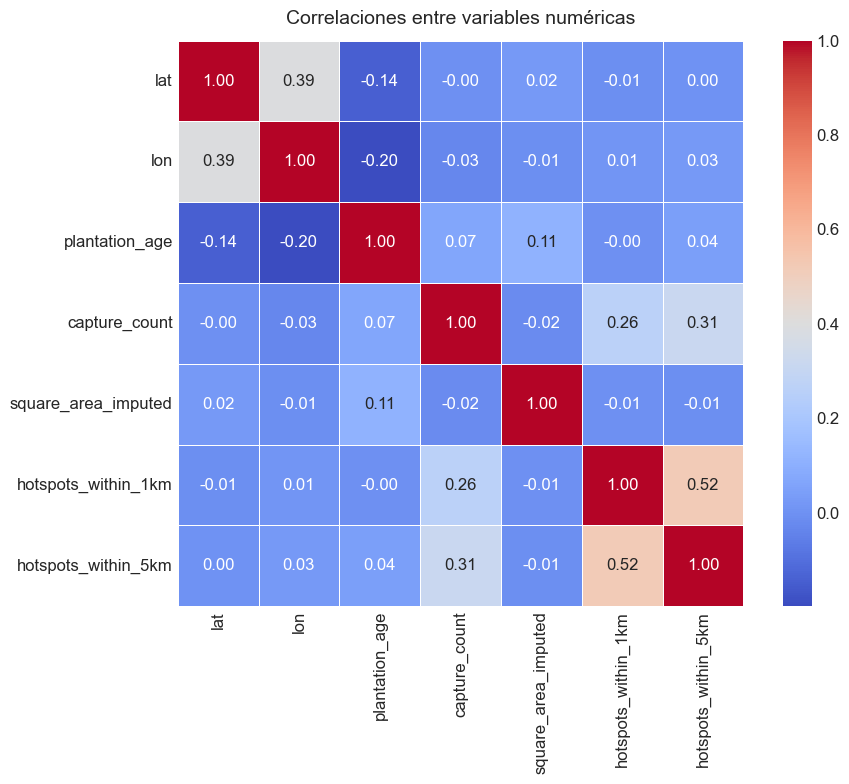

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = [ 'lat', 'lon', 'plantation_age', 'capture_count', 'square_area_imputed', 'hotspots_within_1km', 'hotspots_within_5km']

# Calculamos la matriz de correlación
corr_matrix = df[numerical_features].corr()

# Configuramos el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Generamos el mapa de calor
sns.heatmap(
    corr_matrix,
    annot=True,          
    fmt=".2f",           
    cmap='coolwarm',     
    linewidths=0.5,      
    square=True          
)

# Título del gráfico
plt.title("Correlaciones entre variables numéricas", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

Para `distance_to_nearest_hotspot` tomaremos en cuenta solamente los valores menors a 9999, ya  que este valor era el default para indicar que no  se encontró alguna trampa o punto catalogado como severo.

Y notamos que las correlaciones más fuertes se encuentran entre estas variables:

- `hotspots_within_5km` & `hotspots_within_1km`, que no es una correlación fuerte (porque no llega a 0.70 o -0.70), pero tiene sentido que se dé un valor cercano debido a que las trampas o puntos de infección severa contenidos en 1km también se encuentran contenidos en 5km. Por lo tanto, entre más puntos severos de infección existan a 1km, es probable que el número de focos de infección severos a 5km crezca también.    
- `latitud` y `longitud`, los cuales son parte de la ubicación donde se llevó  a cabo la muestra y muestran una correlación de 0.39. Esto no es algo de notar ya que conocemos que todas las muestras han sido tomadas en 5 estados definidos.

Entonces, con lo anterior, consideramos que podemos eliminar la columna `hotspots_within_1km`, ya que la información de éstas trampas se encuentra contenida en `hotspots_within_5km` y su varianza es bastante menor que la varianza de `hotspots_within_5km`.


In [99]:
df.drop(labels = ['hotspots_within_1km'], inplace=True, axis=1)

### Features categóricos

#### Chi Cuadrado

Iniciaremos con una prueba Chi Cuadrado para nuestas variables categóricas. Usaremos un `p = 0.05` para definir si existe una asociación significativa entre nuestras variables, y en el caso de no haberla estaremos eliminando dichos features.

Por lo anterior, lo que buscamos es conocer si la `severidad` (`severity_encode`) tiene alguna relación con nuestras variables categóricas. Por lo tanto, haremos nuestro test `Chi^2` con base en esta. 

In [ ]:
from scipy.stats import chi2_contingency

categorical_features = [  'state', 'municipality', 'imputation_method', 'critical_season', 'is_hotspot', 'severity', ]
target = 'severity_encoded'

for col in categorical_features:
    print('=' * 70)
    print(f'Prueba Chi Cuadrado para {col} y {target}')
    print('=' * 70)
    
    contingency_table = pd.crosstab( df[col], df[target] )
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi2 Statistic: {chi2}")
    print(f"Grados de libertad: {dof}")
    print(f"Valor-p: {p}")
    
    if p < 0.05:
        print("✅ Existe relación significativa con base a valor-p = 0.05")
    else:
        print("❌ No existe relación significativa con base a valor-p = 0.05")
        
    print('=' * 70)    
    print("\n\n")

Prueba Chi Cuadrado para state y severity_encoded
Chi2 Statistic: 60011.503198353465
Grados de libertad: 12
Valor-p: 0.0
✅ Existe relación significativa con base a 0.05



Prueba Chi Cuadrado para municipality y severity_encoded
Chi2 Statistic: 112290.94731269983
Grados de libertad: 444
Valor-p: 0.0
✅ Existe relación significativa con base a 0.05



Prueba Chi Cuadrado para severity y severity_encoded
Chi2 Statistic: 2483568.0
Grados de libertad: 9
Valor-p: 0.0
✅ Existe relación significativa con base a 0.05



Prueba Chi Cuadrado para imputation_method y severity_encoded
Chi2 Statistic: 48816.56237073586
Grados de libertad: 9
Valor-p: 0.0
✅ Existe relación significativa con base a 0.05



Prueba Chi Cuadrado para critical_season y severity_encoded
Chi2 Statistic: 4116.320285896227
Grados de libertad: 3
Valor-p: 0.0
✅ Existe relación significativa con base a 0.05



Prueba Chi Cuadrado para is_hotspot y severity_encoded
Chi2 Statistic: 827855.9999999998
Grados de libertad: 3
Valor-p: 0

Los resultados anteriores nos muestran lo siguiente:

- Todas nuestras variables categóricas presentan una relación significtiva. 
- `state` tiene una relación significativa con `severity_encode`, lo que tiene sentido ya que la severidad entre estados puede variar.
- Respecto a la variable `municipality`, al tener una cardinalidad alta, no se justifica su permanencia solo con base a `Chi^2`. Esto lo deducimos por el valor ante de `Chi^2` obtenido.
- `imputation_method` parece tener una relación significativa con `severity_code`, lo que nos llama la atención porque esta variable fue creada a partir de rellenar las áreas faltantes de cada predio.
- `critical_season` demuestra un efecto moderado sobre `severity_encode`, lo que tiene sentido debido a que existen meses que se consideran críticos en las plantaciones de agave.
- `is_hotspot` y `severity` tienen un valores elevadísimos debido a que `severity_encode` es una derivación de éstas columnas.

En resumen, esta prueba nos indica que las relaciones entre nuestras variables categóricas no es aleatoria, lo que se demuestra de sobremanera con variables como `is_hotspot` y `severity`. Estas dos últimas features podríamos eliminarlas ya que estarían contenidas en `severity_encode`.

Otro aspecto a tomar en cuenta es que Chi^2 es susceptible al tamaño de la muestra, y por lo tanto podríamos creer erróneamente que todas las variables anteriores son significativas. Por lo tanto, la mejor manera de terminar de descartar nuestras variables categóricas es haciendo otra prueba.

#### Cramer's V

In [ ]:
import json

def cramers_v(x, y):
    
    # Calculamos la tabla de contingencia
    contingency_table = pd.crosstab(x, y)
    
    # Calculamos Chi^2
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    
    min_dim = min(contingency_table.shape) - 1
    
    # Debemos evitar la division por 0
    if min_dim == 0:
        return np.nan
    
    # Retornamos el indicador de Cramer
    return np.sqrt(chi2 / (n * min_dim))

                   
categorical_features = ['state', 'municipality', 'severity', 'imputation_method', 'critical_season', 'is_hotspot']
target = 'severity_encoded'

cramers_results = []

for feature in categorical_features:
    v = cramers_v(df[feature], df[target])
    cramers_results.append(v)
    
for feature, result in zip(categorical_features, cramers_results):
    print(f"{feature} tiene un indice de Cramer de {result}")

state tiene un indice de Cramer de 0.15544588326347383
municipality tiene un indice de Cramer de 0.21263480101588772
severity tiene un indice de Cramer de 1.0
imputation_method tiene un indice de Cramer de 0.14019921081637607
critical_season tiene un indice de Cramer de 0.07051429680136646
is_hotspot tiene un indice de Cramer de 0.9999999999999998


Con esto, nos damos cuenta de que variables o features como `imputation_method`, `is_hotspot` y `critical_season` tienen una asociación débil con la severidad, y por lo tanto estaría  bien eliminarlas. Ahora bien, de las 3 variables anteriores no eliminaremos `critical_season`, ya que el manual operativo indica que los meses de incluidos en `critical_season` es donde más control se debe hacer en los predios de agave.

In [115]:
df.drop(labels=['imputation_method', 'is_hotspot'], inplace=True, axis= 1)

# Columnas o features finales

In [116]:
df.dtypes

tramp_id                               object
sampling_date                  datetime64[ns]
lat                                   float64
lon                                   float64
municipality                           object
square_area                           float64
plantation_age                          int64
capture_count                         float64
state                                  object
severity                               object
square_area_imputed                   float64
month                                   int32
year                                    int32
year_month                             object
day_of_year_sin                       float64
day_of_year_cos                       float64
day_of_week_sin                       float64
day_of_week_cos                       float64
week_of_year_sin                      Float64
week_of_year_cos                      Float64
month_sin                             float64
month_cos                         

# Conlusiones

#### Sobre `imputation_method`

#### Sobre los `features temporales`

#### Sobre las `características espaciales`

#### Sobre `Estado` y `Municipalidad`

### Sobre `text_feature_...`

# Referencias

**Justificación CRISP-ML:**
- Estas transformaciones convierten datos tabulares en texto natural procesable 
  por LLMs (Devlin et al., 2019)
- La categorización semántica mejora la interpretabilidad y aprendizaje de 
  patrones (Brown et al., 2020)
- La reducción de 50+ features numéricas a 6-8 features de texto reduce 
  complejidad manteniendo información relevante